<a href="https://colab.research.google.com/github/iamvarada/colab_ML/blob/main/colored_image_CNN_and_overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## CNN with high resolution colored images of different sizes

## Goal - classify images as cats and dogs

# Problem :::: with Images of diff sizes
# NN need images of same size -- otherwise "flatten" would not work
# With images of different sizes, flatten would result in 1D array of different sizes
# Solution :::: To solve this, we resize all the images to one size and then flatten it

# Problem :::: with color images
# Grayscale images are processed as 2D arrays by computers
# Color images are processed as 3D arrays, where depth is the numebr of color channels.
# Most color images have 3 color channels (RGB). Each color channel is represented by its own 2D arrays
# Solution :::: input shape in the model layer would be (28,28,3), 28x28 pixel width x height

# Convolution in color images : kernel filter is 3D in this as well with the depth = number of color channels
# So for RGB images, kernel filter size  = (y x y x 3) aka 3D filter
# 1 filter for each channel, then simultaneous convolution of filter with the pixel in the corresponding layer....
# We have 3 numbers (one for each layer) => Add all them together and add a bias (usually = 1), that is the resulting output in the corresponding pixel of convoluted image
# In this case, convoluted output is 2D

## Common in CNN to use multiple 3D filters for one image, so the same above convolution step is performed for each 3D filter to output one 2D convoluted output for each 3D filter
# So size of convoluted output image is (y x y x num_filters). 16 filters for a 3D image => size of convoluted image is (y x y x 16)

## Max pooling in 3D images
# Same as 2D but apply max pooling (with certain grid size and stride) for each convoluted output
# Output of max pooling has depth = number of 3D filters applied (which is equal to number of convoluted output layers)

# Defs: 2 of techniques for preventing overfitting

## 1. Image augmentation

# Want to identify the main subject (say dogs) wherever they are in the image (to the side, corner etc..). If training set
# does not have these cases, then CNN does not generalize enough.

## Hence image augmentaiton.. augment the image by applying transformaton (usually rotation, flipping, zoom) to create new images
# and add to the dataset

# 2. Dropout
# During training one part of neurons can end up with very high weight compared to other neurons.
# So for dropping out, we randomly turn off some neurons and perform feed forward and backprop.
# Hence, network becomes more resellient.


In [3]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Download dataset from kaggle

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68606236/68606236 [==============================] - 1s 0us/step


In [5]:
# List the directories in the current runtime (just a tip for future use)
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [7]:
# understanding the data

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print("total training cat images", num_cats_tr)
print("total training dog images", num_dogs_tr)
print("total validation cat images", num_cats_val)
print("total validation dog images", num_dogs_val)

print("total training images", total_train)
print("total validation images", total_val)

total training cat images 1000
total training dog images 1000
total validation cat images 500
total validation dog images 500
total training images 2000
total validation images 1000


In [8]:
# Model params

BATCH_SIZE = 100 # Number of training examples to pass to the model in every epoch while traing before updating weights 
IMG_SHAPE = 150  # Re-sizing images of different size to same size so that we can input it to the model

In [9]:
# Data preparation

train_image_generator = ImageDataGenerator(rescale = 1./255) # Rescale to be b/w 0 to 1 as NN prefer small inputs
validation_image_generator = ImageDataGenerator(rescale = 1./255)

In [10]:
# apply rescaling, resizing, shuffle

train_data_gen = train_image_generator.flow_from_directory(batch_size = BATCH_SIZE, directory = train_dir,
                                                           shuffle = True, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                                           )

val_data_gen = validation_image_generator.flow_from_directory(batch_size = BATCH_SIZE, directory = validation_dir,
                                                           shuffle = False, target_size = (IMG_SHAPE, IMG_SHAPE),
                                                            class_mode = 'binary'
                                                           )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


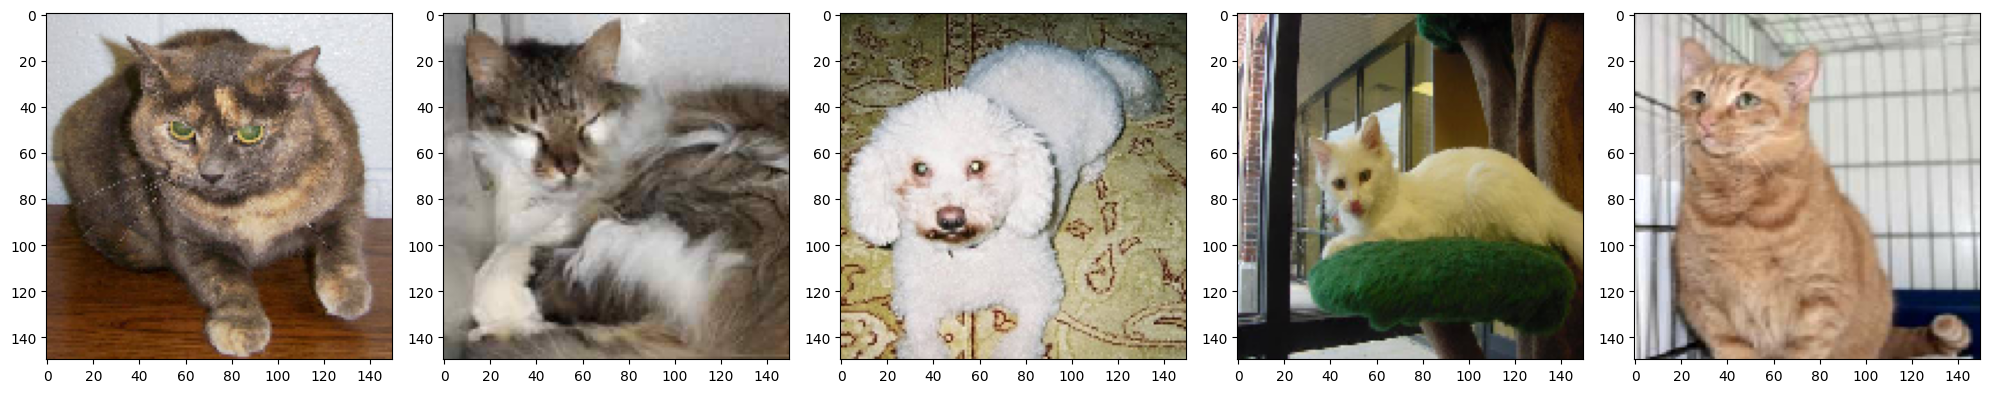

In [11]:
# Visualize the training data

sample_training_images, _ = next(train_data_gen)

# Function to plot certain number of images in row vector
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()


plotImages(sample_training_images[:5]) # Plot first 5 images

In [12]:
# Define the model

model = tf.keras.models.Sequential([
    # 32 outputs from first layer (only first layers has input_shape argument as onlt that takes the input images)
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)), # kernel size 3x3, 3 channels hence the input shape
    tf.keras.layers.MaxPooling2D(2,2),

    # 64 outputs from second layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    # 128 outputs from third layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    # 128 outputs from fourth layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # kernel size 3x3
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), # 512 output neurons from the dense layer
    tf.keras.layers.Dense(2, activation = 'softmax') # PDF output, 2 classes (cats, dogs), hence 2 output neurons
])

In [13]:
# Compile the model

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [14]:
model.summary()

# almost 3.5 million variables!!

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [15]:
EPOCHS = 50 # classic rookie mistake to perform an overfitting --> training loss will be very low (~0), validation loss very high

# using fit_generator() instead of fit() as the training batch samples are coming from ImageDataGenerator
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs = EPOCHS,
    validation_data = val_data_gen,
    validation_steps = int(np.ceil(total_val) / float(BATCH_SIZE))
)

<ipython-input-15-c8a3a4ea8aee>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
20/20 [==============================] - 24s 502ms/step - loss: 0.7808 - accuracy: 0.5075 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 2/50
20/20 [==============================] - 10s 508ms/step - loss: 0.6890 - accuracy: 0.5240 - val_loss: 0.6816 - val_accuracy: 0.5000
Epoch 3/50
20/20 [==============================] - 10s 503ms/step - loss: 0.6781 - accuracy: 0.5560 - val_loss: 0.6696 - val_accuracy: 0.5850
Epoch 4/50
20/20 [==============================] - 10s 503ms/step - loss: 0.6589 - accuracy: 0.5865 - val_loss: 0.6496 - val_accuracy: 0.6050
Epoch 5/50
20/20 [==============================] - 11s 575ms/step - loss: 0.6399 - accuracy: 0.6270 - val_loss: 0.6408 - val_accuracy: 0.6330
Epoch 6/50
20/20 [==============================] - 10s 499ms/step - loss: 0.5785 - accuracy: 0.6905 - val_loss: 0.6943 - val_accuracy: 0.6390
Epoch 7/50
20/20 [==============================] - 10s 503ms/step - loss: 0.5660 - accuracy: 0.6935 - val_loss: 0.5786 - val_accuracy: 0.6980

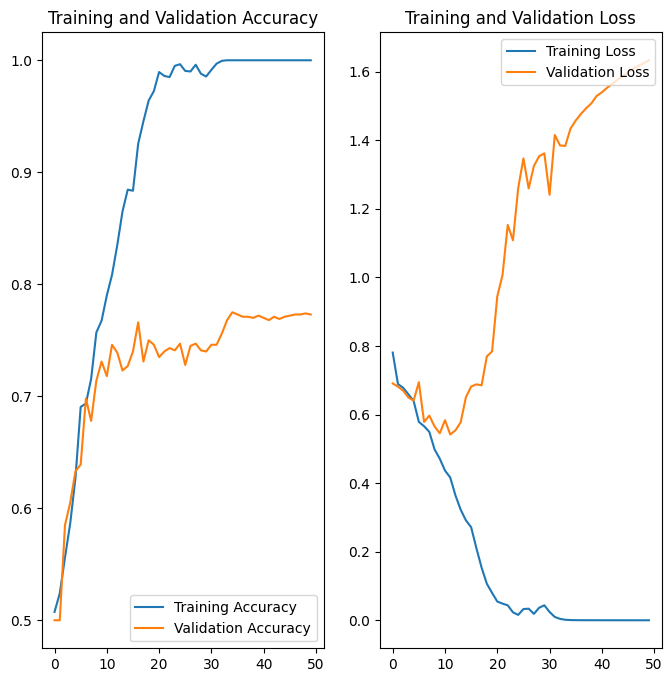

In [16]:
# Plot training and validation loss time-series

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()